### This notebook was one of the first steps toward analyzing HWT forecasts

It was largely supplanted by [`model_vars_rpt_types.ipynb`](model_vars_rpt_types.ipynb) but may still have some helpful tidbits and be easier to follow

In [1]:
from pathlib import Path

import matplotlib.colors as colors
import numpy as np
import pandas as pd
import xarray
from geopy.distance import great_circle
from metpy.units import units
from tqdm import tqdm


# Define distance function
def calculate_distance(lon1, lat1, lon2, lat2):
    return great_circle((lat1, lon1), (lat2, lon2)).miles

In [2]:
idate = pd.to_datetime("20240521")
mem = 3
# Load wind reports data
reports = pd.read_csv("https://www.spc.noaa.gov/climo/reports/240521_rpts_wind.csv")

# Load updraft helicity data from netCDF
updraft_helicity_path = Path("/glade/campaign/mmm/parc/schwartz/HWT2024/mpas")
ipath = updraft_helicity_path / idate.strftime("%Y%m%d%H") / "post" / f"mem_{mem}"
ifiles = list(ipath.glob("*_f?[05]0.nc"))
print(ifiles)
ds0 = xarray.open_mfdataset(
    ifiles, combine="nested", concat_dim="time", drop_variables=["total_precip_hrly"]
)
ds0

[PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2024/mpas/2024052100/post/mem_3/interp_mpas_3km_2024052100_mem3_f050.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2024/mpas/2024052100/post/mem_3/interp_mpas_3km_2024052100_mem3_f100.nc'), PosixPath('/glade/campaign/mmm/parc/schwartz/HWT2024/mpas/2024052100/post/mem_3/interp_mpas_3km_2024052100_mem3_f000.nc')]


<xarray.Dataset> Size: 2GB
Dimensions:                 (time: 3, lat: 1059, lon: 1799)
Dimensions without coordinates: time, lat, lon
Data variables: (12/66)
    latitude                (time, lat, lon) float32 23MB dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    longitude               (time, lat, lon) float32 23MB dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    refl10cm_max            (time, lat, lon) float32 23MB dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    updraft_helicity_max    (time, lat, lon) float32 23MB dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    w_velocity_max          (time, lat, lon) float32 23MB dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    wind_speed_10m_max      (time, lat, lon) float32 23MB dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    ...                      ...
    ushr01                  (time, lat, lon) float32 23MB dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    vshr01                  (time, lat, lon) float32 23MB dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    updraft_helicity_max03  (time, lat, lon) float32 23MB dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    grpl_max                (time, lat, lon) float32 23MB dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    updraft_helicity_max01  (time, lat, lon) float32 23MB dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    rvort1_max              (time, lat, lon) float32 23MB dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
Attributes:
    initializationTime:  2024052100
    forecastHour:        50
    DX:                  3000.0

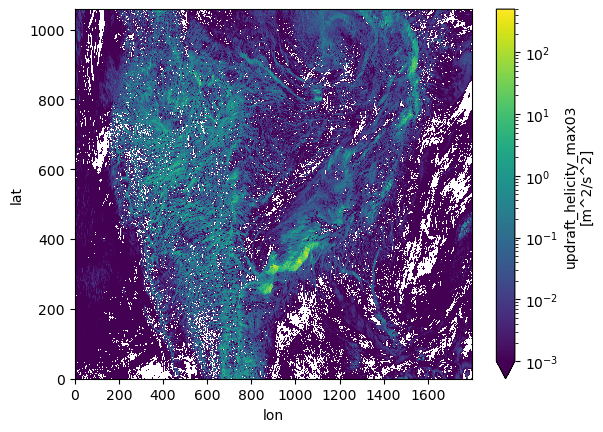

In [3]:
# Multiple thresholds for updraft helicity
helicity_thresholds = [0.1, 1, 10, 100]
ds = ds0.isel(time=0).load()
updraft_helicity = ds.updraft_helicity_max03
norm = colors.LogNorm(vmin=0.001, vmax=500)
updraft_helicity.plot(norm=norm)

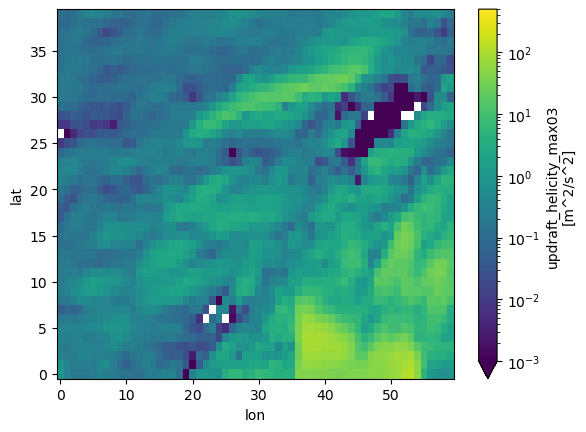

In [4]:
# Subset domain on interesting part
ilats = range(370, 410, 1)
ilons = range(1010, 1070, 1)
updraft_helicity.isel(lat=ilats, lon=ilons).plot(norm=norm)

In [5]:
# Pandas DataFrame filled with zeros
# indexed (rows) by thresholds
# columns are hits, misses, fa, and null
contingency_table = pd.DataFrame(
    0, index=helicity_thresholds, columns=["hits", "misses", "false alarms", "correct nulls"]
)
contingency_table

,hits,misses,false alarms,correct nulls
0.1,0,0,0,0
1.0,0,0,0,0
10.0,0,0,0,0
100.0,0,0,0,0


In [6]:
# Iterate through updraft helicity
for ilat in tqdm(ilats):
    for ilon in ilons:
        lat = ds.latitude.isel(lon=ilon, lat=ilat)
        lon = ds.longitude.isel(lon=ilon, lat=ilat)
        uh = updraft_helicity.isel(lon=ilon, lat=ilat).values

        # Iterate wind reports to update the contingency table
        report_nearby = False
        for index, report in reports.iterrows():
            dist = calculate_distance(lon, lat, report["Lon"], report["Lat"])
            if dist < 25:
                report_nearby = True
                break
        # Get array of boolean values, one for each helicity bin
        # where value is whether helicity bin less than or equal to uh.
        ihigh_helicity = helicity_thresholds <= uh
        if report_nearby:
            # A Boolean True will be cast as 1
            # Boolean False will be cast as 0
            contingency_table["hits"] += ihigh_helicity
            contingency_table["misses"] += ~ihigh_helicity
        else:
            contingency_table["false alarms"] += ihigh_helicity
            contingency_table["correct nulls"] += ~ihigh_helicity

contingency_table

100%|██████████| 40/40 [00:47<00:00,  1.18s/it]


,hits,misses,false alarms,correct nulls
0.1,1018,194,1045,143
1.0,380,832,520,668
10.0,44,1168,173,1015
100.0,0,1212,3,1185


In [7]:
%%time
# cKDTree assumes coordinates are Cartesian (flat)
from scipy.spatial import cKDTree

# Extract latitude, longitude, and updraft helicity values
latitudes = ds.latitude.values
longitudes = ds.longitude.values
updraft_helicities = ds.updraft_helicity_max03.values

uh_coords = np.array(list(zip(latitudes.ravel(), longitudes.ravel())))
uh_tree = cKDTree(uh_coords)

# Prepare wind report coordinates for spatial indexing
wind_coords = np.array(list(zip(reports["Lat"], reports["Lon"])))
wind_tree = cKDTree(wind_coords)

# Threshold distance in miles (converted to degrees)
threshold_distance = 25 / 69  # ~69 miles per degree

# Find all uh points whose distance is at most threshold_distance from wind report
results = wind_tree.query_ball_tree(
    uh_tree,
    r=threshold_distance,
)

CPU times: user 1.4 s, sys: 120 ms, total: 1.52 s
Wall time: 1.52 s


In [8]:
updraft_helicity

<xarray.DataArray 'updraft_helicity_max03' (lat: 1059, lon: 1799)> Size: 8MB
array([[1.2144725e-04, 2.3544495e-09, 3.6979461e-08, ..., 1.1834906e-03,
        2.2672808e-03, 3.4775641e-03],
       [2.9270854e-04, 8.5033542e-05, 1.1674850e-05, ..., 3.1416213e-05,
        1.0111532e-03, 1.8124552e-03],
       [3.1243789e-04, 9.8316319e-05, 8.3797286e-06, ..., 0.0000000e+00,
        0.0000000e+00, 7.9067802e-04],
       ...,
       [4.7098787e-04, 8.3784740e-05, 1.2515178e-04, ..., 0.0000000e+00,
        0.0000000e+00, 1.5190584e-06],
       [1.6672628e-04, 1.3481316e-04, 2.4434426e-04, ..., 2.2180280e-05,
        4.6642253e-05, 4.0383970e-06],
       [6.7541652e-05, 1.9243652e-04, 3.1217936e-04, ..., 1.0833108e-04,
        1.0730174e-04, 3.2197178e-05]], dtype=float32)
Dimensions without coordinates: lat, lon
Attributes:
    units:        m^2/s^2
    description:  updraft_helicity_max03

In [9]:
near_rpt = updraft_helicity.astype(bool)
near_rpt.name = "anything"
near_rpt.attrs["units"] = None
near_rpt

<xarray.DataArray 'anything' (lat: 1059, lon: 1799)> Size: 2MB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False,  True],
       ...,
       [ True,  True,  True, ..., False, False,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Dimensions without coordinates: lat, lon
Attributes:
    units:        None
    description:  updraft_helicity_max03

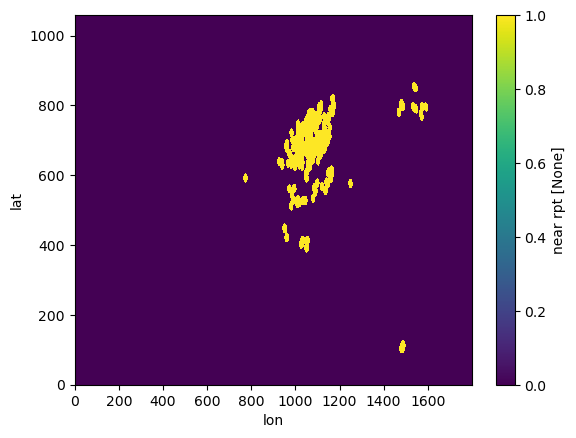

In [10]:
near_rpt = updraft_helicity.astype(bool)
near_rpt.name = "near rpt"
near_rpt.attrs["units"] = None
near_rpt.attrs["description"] = "is near report"
near_rpt[:] = False
for result in results:
    near_rpt.values.put(result, True)
near_rpt_cKDtree = near_rpt
near_rpt.plot()

In [11]:
%%time
# BallTree (with metric = "haversine") assumes spherical coordinates
# We want this.
from sklearn.neighbors import BallTree

uh_tree = BallTree(np.deg2rad(uh_coords), metric="haversine")
import metpy.constants

Re = metpy.constants.earth_avg_radius
r = (25 * units.miles).to("km") / Re
r = r.to_base_units()
# Find all uh points whose distance is at most threshold_distance from wind report
results = uh_tree.query_radius(np.deg2rad(wind_coords), r=r)
near_rpt = updraft_helicity.astype(bool)
near_rpt.name = "near rpt"
near_rpt.attrs["units"] = None
near_rpt[:] = False
for result in results:
    near_rpt.values.put(result, True)
near_rpt.values.sum()

CPU times: user 1.72 s, sys: 63.8 ms, total: 1.78 s
Wall time: 1.84 s


52016

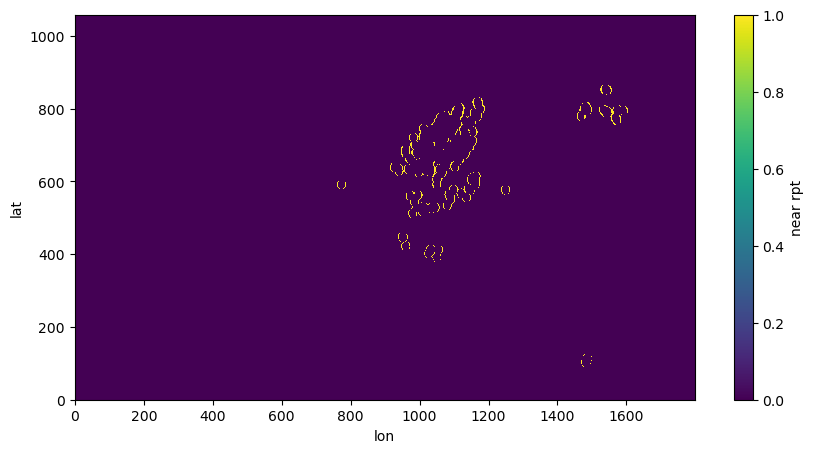

In [12]:
# Differences between scipy.spatial.cKDtree and sklearn.neighbors.BallTree
# Larger near poles
(near_rpt_cKDtree != near_rpt).plot(figsize=(10, 5))

CPU times: user 188 ms, sys: 24.1 ms, total: 212 ms
Wall time: 211 ms


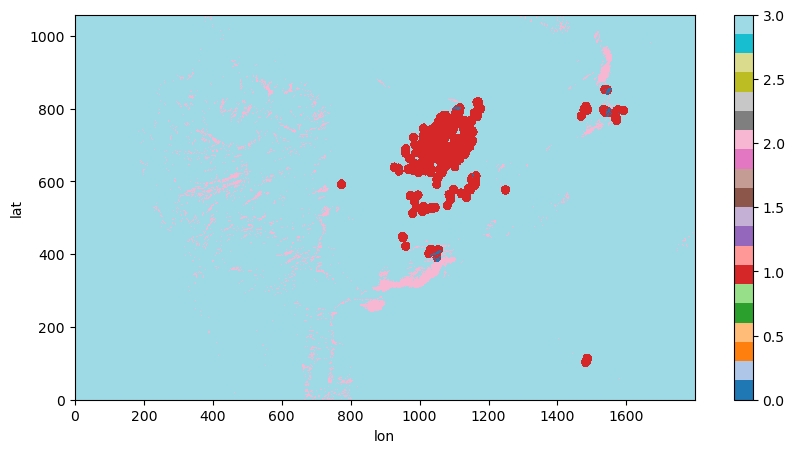

In [13]:
%%time
# single_threshold
thresh = 1
h = near_rpt * (updraft_helicity >= thresh)
m = near_rpt * (updraft_helicity < thresh)
f = ~near_rpt * (updraft_helicity >= thresh)
n = ~near_rpt * (updraft_helicity < thresh)
hmfn = m + f * 2 + n * 3
hmfn.plot(cmap="tab20", figsize=(10, 5))

CPU times: user 212 ms, sys: 72 ms, total: 284 ms
Wall time: 287 ms


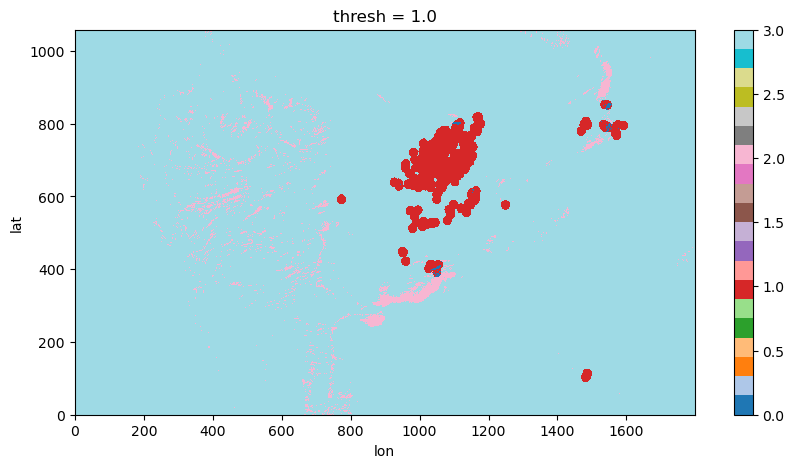

In [14]:
%%time
# multiple thresholds
fy = xarray.DataArray(
    [updraft_helicity >= t for t in helicity_thresholds], dims=["thresh", "lat", "lon"]
).assign_coords(thresh=helicity_thresholds)
h = fy * near_rpt
m = ~fy * near_rpt
f = fy * ~near_rpt
n = ~fy * ~near_rpt
hmfn = m + f * 2 + n * 3
hmfn.sel(thresh=thresh).plot(cmap="tab20", figsize=(10, 5))

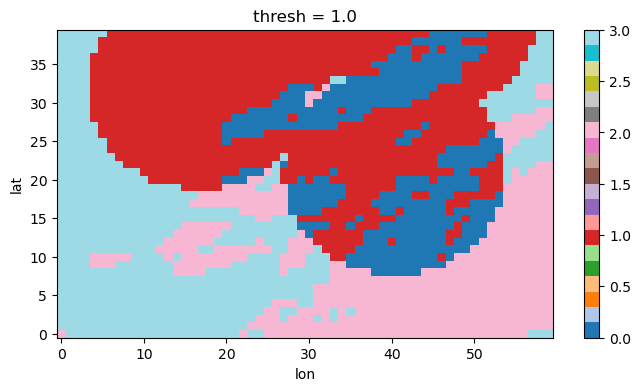

In [15]:
subset = hmfn.isel(lat=ilats, lon=ilons)
subset.sel(thresh=thresh).plot(cmap="tab20", figsize=(8, 4))

In [16]:
contingency_table2 = contingency_table.copy()
contingency_table2[:] = 0
contingency_table2.loc[0.1].iloc[0]

0

In [17]:
for t, row in contingency_table2.iterrows():
    unique, counts = np.unique(subset.sel(thresh=t), return_counts=True)
    for u, c in zip(unique, counts):
        row.iloc[u] = c
contingency_table2

,hits,misses,false alarms,correct nulls
0.1,1018,194,1045,143
1.0,380,832,520,668
10.0,44,1168,173,1015
100.0,0,1212,3,1185


In [18]:
contingency_table

,hits,misses,false alarms,correct nulls
0.1,1018,194,1045,143
1.0,380,832,520,668
10.0,44,1168,173,1015
100.0,0,1212,3,1185


In [19]:
contingency_table.sum(axis="columns")

0.1      2400
1.0      2400
10.0     2400
100.0    2400
dtype: int64